<a href="https://colab.research.google.com/github/Prashanna-Raj-Pandit/Transfer-Learning--TensorFlow/blob/main/02_Transfer_Learning_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine Tuning EfficientNetV2 Food Classification on Food101 dataset

## Running a series of transfer learning experiments
0. model 0 - use frature extraction transfer learning with 10% of training data without data augmentation
1. model 1 - use feature extraction transfer learning with 1% of training data with data augmentation
2. model 2 - use frature extraction transfer learning with 10% of training data with data augmentation
3. model 3 - use fine-tuning transfer learning with 10% of trainig data with data augmanation
4. model 4 - use fine-tuning transfer learning with 100% of training data with data augmentation

In [1]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [2]:
# check GPU
!nvidia-smi

Wed Mar 19 02:47:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Importing helper function

In [3]:
! wget https://raw.githubusercontent.com/Prashanna-Raj-Pandit/Transfer-Learning--TensorFlow/refs/heads/main/helper_functions.py

--2025-03-19 02:47:37--  https://raw.githubusercontent.com/Prashanna-Raj-Pandit/Transfer-Learning--TensorFlow/refs/heads/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10129 (9.9K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.89K  --.-KB/s    in 0s      

2025-03-19 02:47:37 (83.1 MB/s) - ‘helper_functions.py’ saved [10129/10129]



In [4]:
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,walk_through_dir

# Importing dataset

In [5]:
# get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2025-03-19 02:47:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.207, 142.251.31.207, 142.251.18.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  38.8MB/s    in 5.0s    

2025-03-19 02:47:43 (32.3 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [6]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [7]:
#create the training and testing directory paths
train_dir="10_food_classes_10_percent/train"
test_dir="10_food_classes_10_percent/test"

In [8]:

# Create data inputs

IMG_SIZE = (224, 224) # define image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [10]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
#see an example of batch of data
for images, labels in train_data_10_percent.take(1):
  print(images,labels)


tf.Tensor(
[[[[232.        234.        229.       ]
   [232.        234.        229.       ]
   [232.35204   234.07652   229.64285  ]
   ...
   [241.92348   243.07652   237.00514  ]
   [245.35715   241.35715   239.16328  ]
   [245.35715   241.35715   241.07143  ]]

  [[233.        234.        229.       ]
   [233.        234.        229.       ]
   [234.15816   233.21428   231.21428  ]
   ...
   [245.78572   243.19896   233.6429   ]
   [246.99492   241.92856   236.20921  ]
   [247.85715   240.07143   237.07143  ]]

  [[233.78572   233.        231.       ]
   [233.78572   233.        231.       ]
   [234.38264   233.        231.64285  ]
   ...
   [249.4031    243.0459    233.2602   ]
   [250.        240.57143   234.21428  ]
   [250.29079   239.29079   235.71936  ]]

  ...

  [[180.86226   169.86226   149.43373  ]
   [178.85716   167.85716   147.42863  ]
   [177.38263   165.83163   145.57147  ]
   ...
   [180.73982   171.16835   160.52556  ]
   [179.30107   167.27046   155.28577  ]
   [1

# Model 0

In [12]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)),
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])



24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20250319-024753
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 52s 868ms/step - accuracy: 0.2270 - loss: 2.1510 - val_accuracy: 0.7286 - val_loss: 1.4009
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 464ms/step - accuracy: 0.7342 - loss: 1.2667 - val_accuracy: 0.7845 - val_loss: 0.9515
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 466ms/step - accuracy: 0.7849 - loss: 0.9154 - val_accuracy: 0.8339 - val_loss: 0.7410
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - accuracy: 0.8406 - loss: 0.7148 - val_accuracy: 0.8438 - val_loss: 0.6339
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.8658 - loss: 0.6257 - val_accuracy: 0.8717 - val_loss: 0.5621


In [13]:
model_0.evaluate(test_data_10_percent)

79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.8625 - loss: 0.5816


[0.5754949450492859, 0.86080002784729]

In [14]:
# check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number,layer.name)

0 input_layer
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 b

In [15]:
base_model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, None, None, 3)  │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, None, None, 3)  │              0 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, None, None, 32) │            864 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, None, None, 32) │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, None, None, 32) │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, None, None, 16) │          4,608 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, None, None, 16) │             64 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, None, None, 16) │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_conv       │ (None, None, None, 64) │          9,216 │ block1a_project_activ… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_bn         │ (None, None, None, 64) │            256 │ block2a_expand_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_activation │ (None, None, None, 64) │              0 │ block2a_expand_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_project_conv      │ (None, None, None, 32) │          2,048 │ block2a_expand_activa… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_project_bn        │ (None, None, None, 32) │            128 │ block2a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

## Model 0 summary

# Model 1

In [16]:
# getting dataset
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip") # the function is defined in helper function


--2025-03-19 02:49:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.207, 173.194.79.207, 108.177.96.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  36.3MB/s    in 4.1s    

2025-03-19 02:49:53 (31.1 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [17]:
# creating training and testing directory
train_dir_1_percent="/content/10_food_classes_1_percent/train"
test_dir_1_percent="/content/10_food_classes_1_percent/test"

In [18]:
# lets walk through the directory to check the data with the help of helper_function.py
walk_through_dir(train_dir_1_percent)
walk_through_dir(test_dir_1_percent)

There are 10 directories and 0 images in '/content/10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '/content/10_food_classes_1

creating data loaders

In [19]:
IMAGE_SIZE=(224,224)
BATCH_SIZE=32
train_data_1_percent=tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_1_percent,
                                                                         label_mode="categorical",
                                                                         image_size=IMG_SIZE,
                                                                         batch_size=BATCH_SIZE)
test_data_1_percent=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir_1_percent,
                                                                        label_mode="categorical",
                                                                        image_size=IMAGE_SIZE,
                                                                        batch_size=BATCH_SIZE)


Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Data augmentation

tf.keras.layers.experimantal.preprocessing()

In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation

data_augmentation = keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomTranslation(height_factor=0.2, width_factor=0.2),
], name="data_augmentation")


be sure to pass training=True to your data_augmentation() model, otherwise the image may not augment (data augmentation only works in training mode).

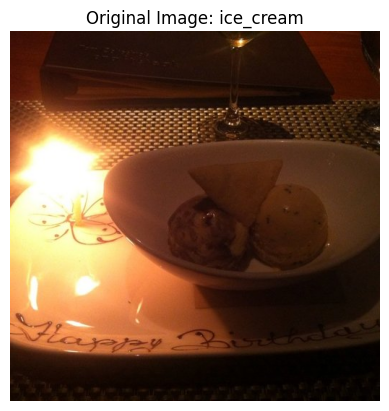

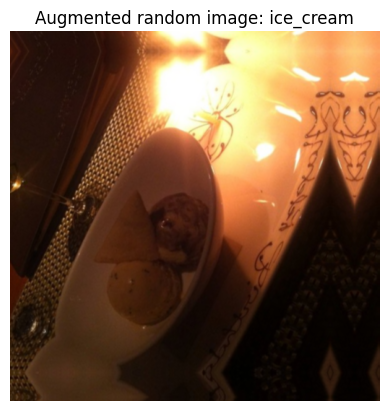

In [21]:
#view a random image and compare it with augmented image
import matplotlib.pyplot as plt
import random
import os
import matplotlib.image as mpimg

target_class=random.choice(train_data_1_percent.class_names)
target_dir=os.path.join("10_food_classes_1_percent/train",target_class)
random_img_path=os.path.join(target_dir,random.choice(os.listdir(target_dir)))
random_image=mpimg.imread(random_img_path)
plt.imshow(random_image)
plt.axis(False)
plt.title("Original Image: "+target_class)

# Augment the image
augmented_img = data_augmentation(random_image, training=True)
plt.figure()
plt.imshow(augmented_img/255.) # requires normalization after augmentation
plt.title(f"Augmented random image: {target_class}")
plt.axis(False);

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

Explanation of the Flow:
Input Layer:

The input tensor has a shape of (None, 224, 224, 3).

Data Augmentation:

The data_augmentation layer is applied to the input tensor, producing an augmented tensor of the same shape (None, 224, 224, 3).

Base Model:

The augmented tensor is passed to the base_model (EfficientNetV2B0), which outputs a tensor of shape (None, 7, 7, 1280) (assuming EfficientNetV2B0's default output shape).

Global Average Pooling:

The GlobalAveragePooling2D layer reduces the spatial dimensions to (None, 1280).

Output Layer:

A Dense layer with 10 units and softmax activation is added for classification.

Model Compilation and Training:

The model is compiled with categorical_crossentropy loss and trained using the provided dataset.

inputs (224, 224, 3) → data_augmentation → augmented tensor (224, 224, 3) → base_model → ...

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation

# Data augmentation layer
data_augmentation = keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomTranslation(height_factor=0.2, width_factor=0.2),
], name="data_augmentation")

# 1. Create base model with tf.keras.applications
input_shape = (224, 224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create input layer
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")
print(f"Input shape: {inputs.shape}")

# 4. Apply data augmentation to the inputs
x = data_augmentation(inputs)
print(f"Augmented shape: {x.shape}")

# 5. Pass the augmented inputs to the base_model
x = base_model(x)
print(f"Base shape: {x.shape}")

# 6. Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# 7. Add a dense layer on top as an output layer
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Create the model using inputs and outputs
model_1 = keras.Model(inputs, outputs)

# 9. Compile the model
model_1.compile(loss="categorical_crossentropy",  # Fixed typo: categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model
history_model_1 = model_1.fit(train_data_1_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_1_percent),  # Fixed typo: steps_per_epoch
                              validation_data=test_data_1_percent,
                              validation_steps=int(0.25 * len(test_data_1_percent)),
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="1_percent_feature_extractor")])

Input shape: (None, 224, 224, 3)
Augmented shape: (None, 224, 224, 3)
Base shape: (None, 7, 7, 1280)
Saving TensorBoard log files to: transfer_learning/1_percent_feature_extractor/20250319-024957
Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.0488 - loss: 2.5210 - val_accuracy: 0.1924 - val_loss: 2.2362
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step - accuracy: 0.1268 - loss: 2.2499 - val_accuracy: 0.2368 - val_loss: 2.1504
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.3205 - loss: 2.0418 - val_accuracy: 0.2993 - val_loss: 2.0714
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step - accuracy: 0.3680 - loss: 2.0289 - val_accuracy: 0.3174 - val_loss: 2.0025
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 799ms/step - accuracy: 0.3992 - loss: 1.8592 - val_accuracy: 0.3553 - val_loss: 1.9269


## Model 1 Summary

In [23]:
model_1.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

In [24]:
# evaluate our model on full test dataset. we only validate 25% during training
model_1_eval_results=model_1.evaluate(test_data_1_percent)
model_1_eval_results


79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.3589 - loss: 1.9418


[1.9517066478729248, 0.36160001158714294]

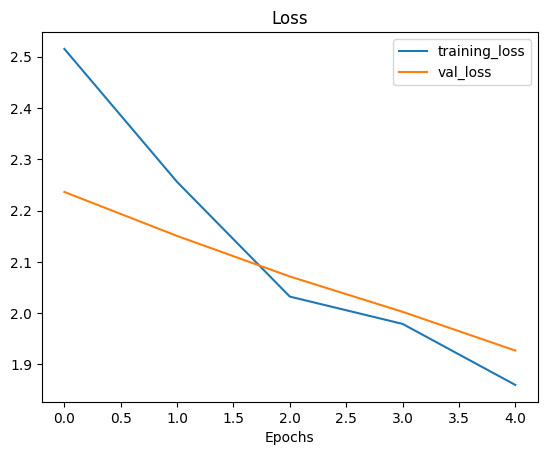

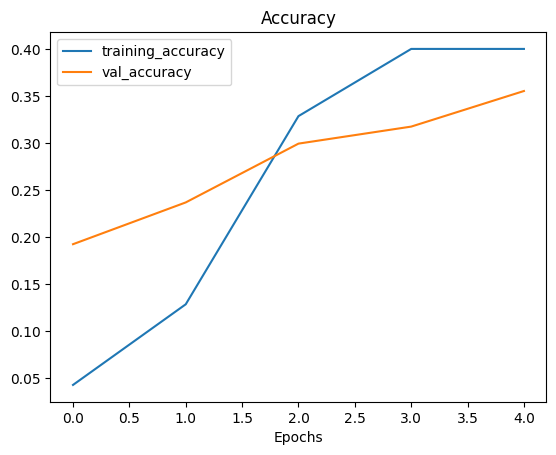

In [25]:
# lets visualize loss curves
plot_loss_curves(history=history_model_1) # defined in helper function

# Model 2

In [26]:
# Model 2
base_model.trainable=False
inputs=tf.keras.layers.Input(shape=(224,224,3),name="input_layer")
augmentation_layer=data_augmentation(inputs)
x=base_model(augmentation_layer,training=False)
x=layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs=tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)
model_2=tf.keras.Model(inputs,outputs)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_2_history=model_2.fit(train_data_10_percent,
                            epochs=5,
                            steps_per_epoch=len(train_data_10_percent),
                            validation_data=test_data_10_percent,
                            validation_steps=int(0.25*len(test_data_10_percent)),
                            callbacks=[create_tensorboard_callback("transfer_learning","10_percent_feature_extractor")])

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extractor/20250319-025031
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 304ms/step - accuracy: 0.2695 - loss: 2.1506 - val_accuracy: 0.5921 - val_loss: 1.5602
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.5529 - loss: 1.5706 - val_accuracy: 0.7303 - val_loss: 1.1481
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.7034 - loss: 1.2632 - val_accuracy: 0.7533 - val_loss: 0.9477
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.7244 - loss: 1.0673 - val_accuracy: 0.7895 - val_loss: 0.8359
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.7254 - loss: 0.9666 - val_accuracy: 0.8092 - val_loss: 0.7203


### Creating Model Checkpoint callback

In [27]:
# set checkpoint path
checkpoint_path="checkpoint/10_percent_model_checkpoint.weights.h5"
# create a model checkpoint callback that saves the model waights only
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                       monitor='val_loss',
                                                       save_weights_only=True,
                                                       save_freq='epoch',
                                                       save_best_only=False,
                                                       verbose=1)

In [28]:
model_2_history_with_checkpoint=model_2.fit(train_data_10_percent,
                                            epochs=5,
                                            steps_per_epoch=len(train_data_10_percent),
                                            validation_data=test_data_10_percent,
                                            validation_steps=int(0.25*len(test_data_10_percent)),
                                            callbacks=[create_tensorboard_callback("transfer_learning","10_percent_feature_extractor_2"),checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extractor_2/20250319-025113
Epoch 1/5
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.7369 - loss: 0.8761
Epoch 1: saving model to checkpoint/10_percent_model_checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - accuracy: 0.7388 - loss: 0.8752 - val_accuracy: 0.8158 - val_loss: 0.6780
Epoch 2/5
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7508 - loss: 0.8790
Epoch 2: saving model to checkpoint/10_percent_model_checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.7528 - loss: 0.8736 - val_accuracy: 0.8141 - val_loss: 0.6326
Epoch 3/5
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7781 - loss: 0.8050
Epoch 3: saving model to checkpoint/10_percent_model_checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.7789 - loss: 0.8030 - val_accuracy: 0.8257 - val_loss: 0.5848
Epoch 4/5
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7949 - lo

### Model 0 vs Model 2

In [29]:
model_0.evaluate(test_data_10_percent)

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.8606 - loss: 0.5831


[0.5754949450492859, 0.86080002784729]

In [30]:
model_2_eval_result=model_2.evaluate(test_data_10_percent)
model_2_eval_result

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.8371 - loss: 0.5460


[0.5409554839134216, 0.8392000198364258]

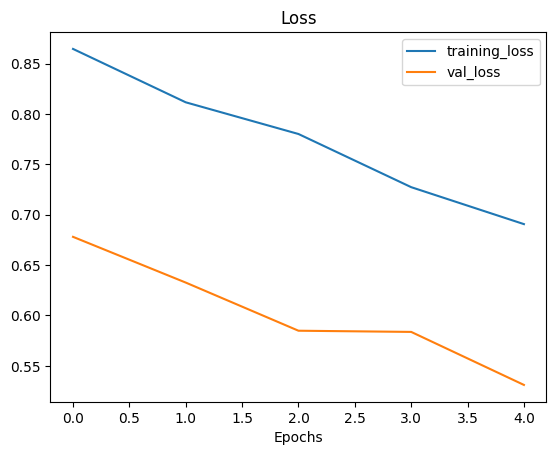

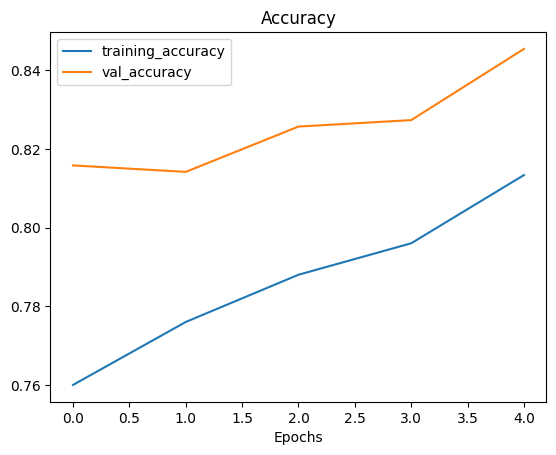

In [31]:
plot_loss_curves(history=model_2_history_with_checkpoint)

### Loading in checkpointed weights
Loading in checkpointed weights returns a model to a specific checkpoint.

In [32]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)


In [33]:
# Evaluating model 2 with loaded results
loaded_weights_model_results=model_2.evaluate((test_data_10_percent))


79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.8444 - loss: 0.5387


In [34]:
model_1_eval_results==loaded_weights_model_results

False

In [35]:
loaded_weights_model_results

[0.5409553050994873, 0.8392000198364258]

In [36]:
model_2_eval_result

[0.5409554839134216, 0.8392000198364258]

There is slight differences in values. it is because how computer store numbers. Lets see if the values are close or not using python function

In [37]:
import numpy as np
np.isclose(np.array(model_2_eval_result),np.array(loaded_weights_model_results))

array([ True,  True])

# Model 3: Fine Tune

In [38]:
# checking trainable layers
for layer in model_2.layers:
  print(layer.name,layer.trainable)

input_layer True
data_augmentation True
efficientnetv2-b0 False
global_average_pooling_layer True
output_layer True


In [39]:
# lets check efficientnetv2-b0
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name,layer.trainable)

0 input_layer_2 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dw

In [40]:
# lets freeze all the layers except the last 10
base_model.trainable=True
for layer in base_model.layers[:-10]:
  layer.trainable=False

# Recompiliing: because we make changes to our base model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # we always lower the LR by 10X in fine tune to reduce overfitting
                metrics=['accuracy'])

In [41]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i,layer.name,layer.trainable)

0 input_layer_2 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dw

In [42]:
# Fine tune for another 5 epochs
fine_tune_epochs=5+5 # one fine was previous
# Refit
model_2_history_fine_tuned=model_2.fit(train_data_10_percent,
                                       epochs=fine_tune_epochs,
                                       validation_data=test_data_10_percent,
                                       validation_steps=int(0.25*len(test_data_10_percent)),
                                       initial_epoch=model_2_history.epoch[-1], # fine tune from previous last epoch
                                       callbacks=[create_tensorboard_callback(dir_name="transfer_learning",experiment_name="model_2_fine_tune")])

Saving TensorBoard log files to: transfer_learning/model_2_fine_tune/20250319-025158
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 274ms/step - accuracy: 0.7727 - loss: 0.9156 - val_accuracy: 0.8306 - val_loss: 0.6250
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.8066 - loss: 0.7642 - val_accuracy: 0.8421 - val_loss: 0.5929
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - accuracy: 0.8370 - loss: 0.7278 - val_accuracy: 0.8520 - val_loss: 0.5518
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.8380 - loss: 0.7030 - val_accuracy: 0.8372 - val_loss: 0.5181
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.8198 - loss: 0.7237 - val_accuracy: 0.8503 - val_loss: 0.4986
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 339ms/step - accuracy: 0.8362 - loss: 0.6301 - val_accuracy: 0.8668 - val_loss: 0.4571


### Fine tuned vs model 2

In [43]:
# model 3 is the fined tuned model 2
model_3_eval_results=model_2.evaluate(test_data_10_percent)
model_3_eval_results

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.8562 - loss: 0.4741


[0.4686812460422516, 0.8587999939918518]

In [44]:
# before fine tuning
model_2_eval_result

[0.5409554839134216, 0.8392000198364258]

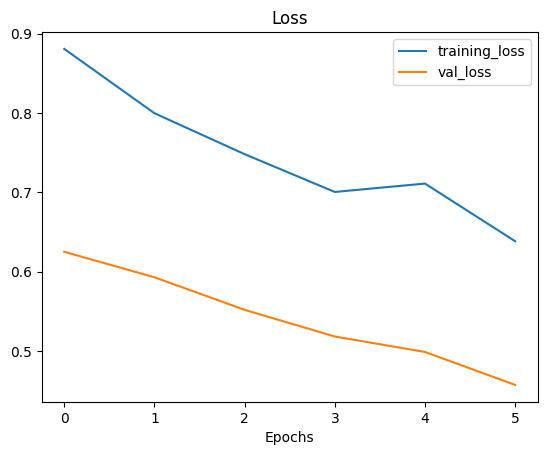

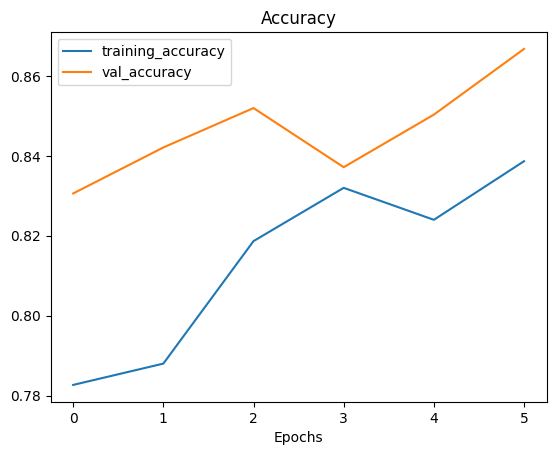

In [45]:
plot_loss_curves(history=model_2_history_fine_tuned)

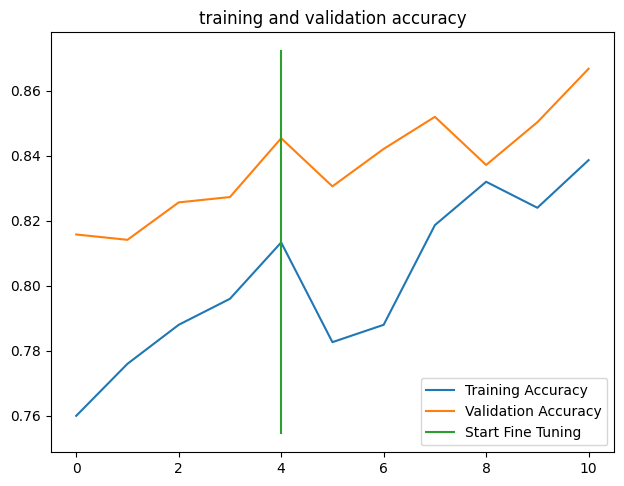

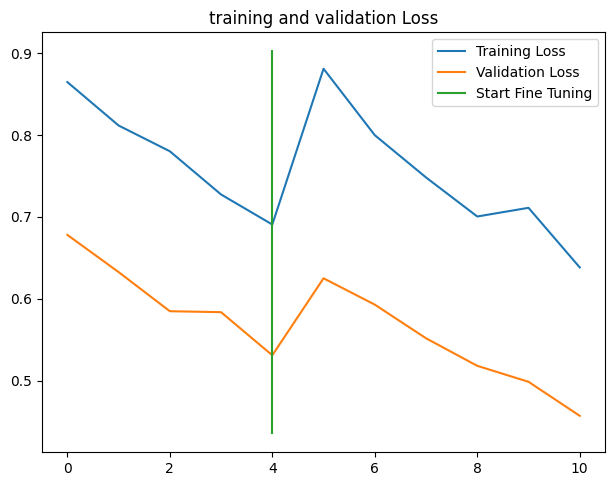

In [46]:
# creatinf a function to compare histories
def compare_histories(original_history,new_history,initial_epoch=5):
  """
  Function to compare two history objects.
  """
  accuracy=original_history.history['accuracy']
  loss=original_history.history['loss']
  val_accuracy=original_history.history['val_accuracy']
  val_loss=original_history.history['val_loss']

  # combining new with original
  total_accuracy=accuracy+new_history.history['accuracy']
  total_loss=loss+new_history.history['loss']
  total_val_accuracy=val_accuracy+new_history.history['val_accuracy']
  total_val_loss=val_loss+new_history.history['val_loss']
  # For accuracy
  plt.figure(figsize=(16,12))
  plt.subplot(2,2,1)
  plt.plot(total_accuracy,label="Training Accuracy")
  plt.plot(total_val_accuracy,label="Validation Accuracy")
  plt.plot([initial_epoch-1,initial_epoch-1],plt.ylim(),label="Start Fine Tuning")
  plt.legend(loc='lower right')
  plt.title("training and validation accuracy")
  # for loss
  plt.figure(figsize=(16,12))
  plt.subplot(2,2,2)
  plt.plot(total_loss,label="Training Loss ")
  plt.plot(total_val_loss,label="Validation Loss ")
  plt.plot([initial_epoch-1,initial_epoch-1],plt.ylim(),label="Start Fine Tuning")
  plt.legend(loc='upper right')
  plt.title("training and validation Loss")
compare_histories(model_2_history_with_checkpoint,model_2_history_fine_tuned)

# Model 4 : Fine Tune

In [47]:
# Getting Dataset
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2025-03-19 02:52:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.207, 173.194.79.207, 108.177.96.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  34.4MB/s    in 16s     

2025-03-19 02:53:12 (31.5 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [48]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.

In [49]:
# Directory path
train_data_100_percent_dir="/content/10_food_classes_all_data/train"
test_data_100_percent_dir="/content/10_food_classes_all_data/test"

In [50]:
# creating dataset: Turn into batches
IMAGE_SIZE=(224,224)
BATCH_SIZE=32
train_dataset_100_percent=tf.keras.preprocessing.image_dataset_from_directory(train_data_100_percent_dir,
                                                                  label_mode="categorical",
                                                                  image_size=IMAGE_SIZE,
                                                                  batch_size=BATCH_SIZE,
                                                                  )
test_dataset_100_percent=tf.keras.preprocessing.image_dataset_from_directory(test_data_100_percent_dir,
                                                                             label_mode="categorical",
                                                                             image_size=IMAGE_SIZE,
                                                                             batch_size=BATCH_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [51]:
base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable=False
inputs=tf.keras.layers.Input(shape=(224,224,3),name="input_layer")
x=data_augmentation(inputs)
x=base_model(x)
x=tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs=tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)
model_4=tf.keras.Model(inputs,outputs)
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

TO make sure it start from the same checkpoint, we can load the checkpointed weights from checkpoint path

In [52]:
model_4.load_weights(checkpoint_path)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [53]:
model_4.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,932,122 (22.63 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [54]:
for num,layer in enumerate(model_4.layers[2].layers):
  print(num,layer.name,layer.trainable)

0 input_layer_4 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dw

In [55]:
# unfreezing the last 10 layer of model
model_4.layers[2].trainable=True
for layer in model_4.layers[2].layers[:-10]:
  layer.trainable=False

In [56]:
for num,layer in enumerate(model_4.layers[2].layers):
  print(num,layer.name,layer.trainable)

0 input_layer_4 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dw

In [57]:
# recompile
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [71]:
fine_tune_epochs_model_4=5+5
model_4_history=model_4.fit(train_dataset_100_percent,
                            epochs=fine_tune_epochs_model_4,
                            validation_data=test_dataset_100_percent,
                            validation_steps=int(0.25*len(test_dataset_100_percent)),
                            initial_epoch=model_2_history_fine_tuned.epoch[-1],
                            callbacks=[create_tensorboard_callback(dir_name="transfer_learning",experiment_name="model_4_fine_tune_100_percent")]
                            )

Saving TensorBoard log files to: transfer_learning/model_4_fine_tune_100_percent/20250319-032152
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - accuracy: 0.7773 - loss: 0.7472 - val_accuracy: 0.8750 - val_loss: 0.3681


In [72]:
results_fine_tune_model_4=model_4.evaluate(test_dataset_100_percent)
results_fine_tune_model_4

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.8777 - loss: 0.3689


[0.3469970226287842, 0.8835999965667725]

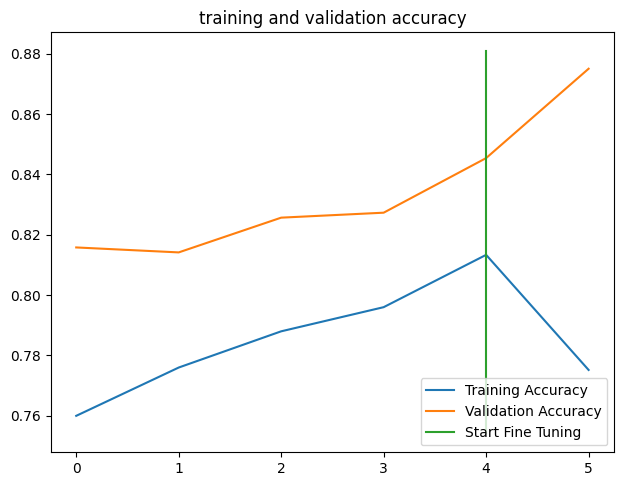

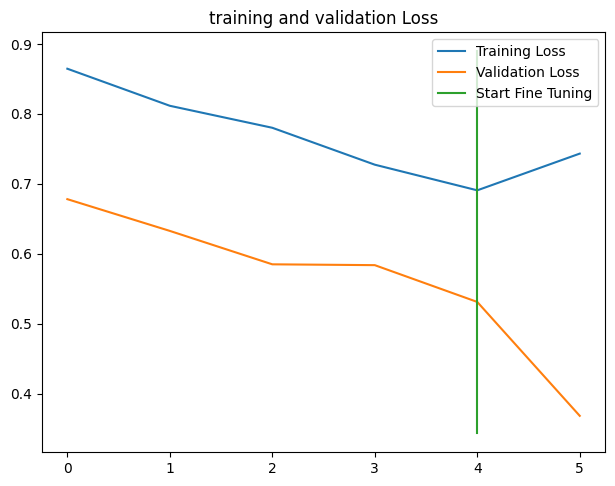

In [73]:
compare_histories(model_2_history_with_checkpoint,model_4_history)

# View in Tensorboard


In [70]:
!tensorboard --logdir ./transfer_learning --load_fast=true

2025-03-19 03:12:07.799462: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742353927.821224    7904 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742353927.827451    7904 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.18.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C
